In [1]:
import os
from options.test_options import TestOptions
import sys
from utils.NiftiDataset import *
import utils.NiftiDataset as NiftiDataset_testing
from torch.utils.data import DataLoader
from models import create_model
import math
from torch.autograd import Variable
from tqdm import tqdm
import datetime

In [2]:
def from_numpy_to_itk(image_np, image_itk):
    image_np = np.transpose(image_np, (2, 1, 0))
    image = sitk.GetImageFromArray(image_np)
    image.SetOrigin(image_itk.GetOrigin())
    image.SetDirection(image_itk.GetDirection())
    image.SetSpacing(image_itk.GetSpacing())
    return image

In [3]:
def prepare_batch(image, ijk_patch_indices):
    image_batches = []
    for batch in ijk_patch_indices:
        image_batch = []
        for patch in batch:
            image_patch = image[patch[0]:patch[1], patch[2]:patch[3], patch[4]:patch[5]]
            image_batch.append(image_patch)

        image_batch = np.asarray(image_batch)
        # image_batch = image_batch[:, :, :, :, np.newaxis]
        image_batches.append(image_batch)

        print(image_batch.shape)

    return image_batches

### Load image

In [4]:
reader = sitk.ImageFileReader()
reader.SetFileName('/media/hdd/levibaljer/ExperimentingKhula/images/0.nii.gz')
image = reader.Execute()

In [5]:
reader2 = sitk.ImageFileReader()
reader2.SetFileName('/media/hdd/levibaljer/ExperimentingKhula/labels/0.nii.gz')
label = reader2.Execute()

In [6]:
print(type(image))

<class 'SimpleITK.SimpleITK.Image'>


In [7]:
print(type(label))

<class 'SimpleITK.SimpleITK.Image'>


### Check Intensity range

In [8]:
filter = sitk.MinimumMaximumImageFilter()
filter.Execute(image);
ImageHighestIntensity = filter.GetMaximum();
ImageLowestIntensity = filter.GetMinimum();

In [9]:
print(ImageHighestIntensity)
print(ImageLowestIntensity)

64013.0
0.0


### Check Intensity range after Normalization

In [10]:
image = Normalization(image)

In [11]:
label = Normalization(label)

In [12]:
filter = sitk.MinimumMaximumImageFilter()
filter.Execute(image);
ImageHighestIntensity = filter.GetMaximum();
ImageLowestIntensity = filter.GetMinimum();

In [13]:
print(ImageHighestIntensity)
print(ImageLowestIntensity)

254.99999999999997
0.0


### Additional Preproc

In [14]:
castImageFilter = sitk.CastImageFilter()
castImageFilter.SetOutputPixelType(sitk.sitkFloat32)
image = castImageFilter.Execute(image)

In [15]:
label = castImageFilter.Execute(label)

In [16]:
# create empty label in pair with transformed image
label_tfm = sitk.Image(image.GetSize(), sitk.sitkFloat32)
label_tfm.SetOrigin(image.GetOrigin())
label_tfm.SetDirection(image.GetDirection())
label_tfm.SetSpacing(image.GetSpacing())

In [17]:
print(image.GetSize())

(144, 256, 256)


### Preparing variables for patch-wise prediction

In [18]:
sample = {'image': image, 'label': label_tfm}

In [19]:
transforms1 = [
        NiftiDataset_testing.Resample((0.45, 0.45, 0.45), False)
    ]

transforms2 = [
    NiftiDataset_testing.Padding((128, 128, 64))
]

In [20]:
for transform in transforms1:
    sample = transform(sample)

In [21]:
image_tfm, label_tfm = sample['image'], sample['label']

In [22]:
# convert image to numpy array
image_np = sitk.GetArrayFromImage(image_tfm)
label_np = sitk.GetArrayFromImage(label_tfm)

label_np = np.asarray(label_np, np.float32)

# unify numpy and sitk orientation
image_np = np.transpose(image_np, (2, 1, 0))
label_np = np.transpose(label_np, (2, 1, 0))

In [24]:
# keeping track on how much padding will be performed before the inference
image_array = sitk.GetArrayFromImage(sample['image'])
pad_x = 128 - (128 - image_array.shape[2])
pad_y = 128 - (128 - image_array.shape[1])
pad_z = 64 - (64 - image_array.shape[0])

image_pre_pad = sample['image']

In [25]:
print(image_np.shape)

(144, 256, 256)


### Carrying out patch-wise prediction

In [26]:
inum = int(math.ceil((image_np.shape[0] - 128) / float(32))) + 1
jnum = int(math.ceil((image_np.shape[1] - 128) / float(32))) + 1
knum = int(math.ceil((image_np.shape[2] - 64) / float(32))) + 1

In [27]:
print(inum, jnum, knum)

2 5 7


In [28]:
patch_total = 0
ijk_patch_indices = []
ijk_patch_indicies_tmp = []

In [29]:
for i in range(inum):
    for j in range(jnum):
        for k in range(knum):
            if patch_total % 1 == 0:
                ijk_patch_indicies_tmp = []

            istart = i * 32
            if istart + 128 > image_np.shape[0]:  # for last patch
                istart = image_np.shape[0] - 128
            iend = istart + 128

            jstart = j * 32
            if jstart + 128 > image_np.shape[1]:  # for last patch
                jstart = image_np.shape[1] - 128
            jend = jstart + 128

            kstart = k * 64
            if kstart + 64 > image_np.shape[2]:  # for last patch
                kstart = image_np.shape[2] - 64
            kend = kstart + 64

            ijk_patch_indicies_tmp.append([istart, iend, jstart, jend, kstart, kend])

            if patch_total % 1 == 0:
                ijk_patch_indices.append(ijk_patch_indicies_tmp)

            patch_total += 1

In [30]:
print((ijk_patch_indices[19]))

[[0, 128, 64, 192, 192, 256]]


In [31]:
ijk_patch_strings = []
for ijk_patch in ijk_patch_indices:
    ijk_patch_strings.append(' '.join([str(i) for i in ijk_patch[0]]))

In [32]:
print(len(set(ijk_patch_strings)))

40


In [33]:
oc_set = set()
res = []
for idx, val in enumerate(ijk_patch_strings):
    if val not in oc_set:
        oc_set.add(val)         
    else:
        res.append(idx)
print(res)  

[4, 5, 6, 11, 12, 13, 18, 19, 20, 25, 26, 27, 32, 33, 34, 39, 40, 41, 46, 47, 48, 53, 54, 55, 60, 61, 62, 67, 68, 69]


In [34]:
uniques = []
for i in range(70):
    if i not in res:
        uniques.append(i)
print(uniques)

[0, 1, 2, 3, 7, 8, 9, 10, 14, 15, 16, 17, 21, 22, 23, 24, 28, 29, 30, 31, 35, 36, 37, 38, 42, 43, 44, 45, 49, 50, 51, 52, 56, 57, 58, 59, 63, 64, 65, 66]


In [35]:
ijk_patch_indices_unique = []
for i in uniques:
    ijk_patch_indices_unique.append(ijk_patch_indices[i])

In [36]:
batches = prepare_batch(image_np, ijk_patch_indices)

(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 1

In [37]:
batches_unique = prepare_batch(image_np, ijk_patch_indices_unique)

(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)


In [51]:
print(len(batches[0][0]))

128


In [52]:
batch = batches[4]

batch = (batch - 127.5) / 127.5

batch = torch.from_numpy(batch[np.newaxis, :, :, :])

print(batch.shape)

torch.Size([1, 1, 128, 128, 64])


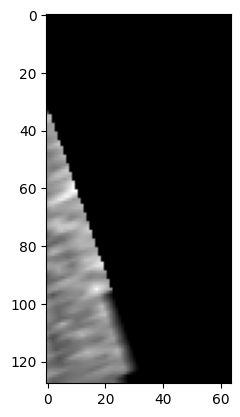

In [53]:
import matplotlib.pyplot as plt
plt.imshow(batch[0, 0, 64, :, :].numpy(), cmap='gray')

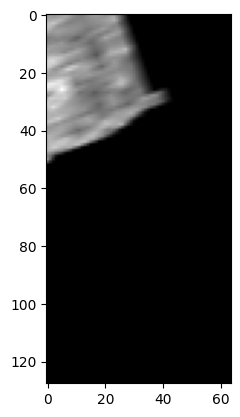

In [54]:
import matplotlib.pyplot as plt
for i in range(len(batches)):
    batch = batches[i]
    batch = (batch - 127.5) / 127.5
    batch = torch.from_numpy(batch[np.newaxis, :, :, :])
    # plt.figure()
    plt.imshow(batch[0, 0, 30, :, :].numpy(), cmap='gray')

In [ ]:
# ## Alternative with 64, 64, 64 patches

# for i in range(inum):
#     for j in range(jnum):
#         for k in range(knum):
#             if patch_total % 1 == 0:
#                 ijk_patch_indicies_tmp = []

#             istart = i * 32
#             if istart + 64 > image_np.shape[0]:  # for last patch
#                 istart = image_np.shape[0] - 64
#             iend = istart + 64

#             jstart = j * 32
#             if jstart + 64 > image_np.shape[1]:  # for last patch
#                 jstart = image_np.shape[1] - 64
#             jend = jstart + 64

#             kstart = k * 64
#             if kstart + 64 > image_np.shape[2]:  # for last patch
#                 kstart = image_np.shape[2] - 64
#             kend = kstart + 64

#             ijk_patch_indicies_tmp.append([istart, iend, jstart, jend, kstart, kend])

#             if patch_total % 1 == 0:
#                 ijk_patch_indices.append(ijk_patch_indicies_tmp)

#             patch_total += 1

## Trying out random crop and modifying

In [88]:
reader = sitk.ImageFileReader()
reader.SetFileName('/media/hdd/levibaljer/ExperimentingKhula/images/0.nii.gz')
image = reader.Execute()

In [89]:
reader2 = sitk.ImageFileReader()
reader2.SetFileName('/media/hdd/levibaljer/ExperimentingKhula/labels/0.nii.gz')
label = reader2.Execute()

In [45]:
image = Normalization(image)
label = Normalization(label)

castImageFilter = sitk.CastImageFilter()
castImageFilter.SetOutputPixelType(sitk.sitkFloat32)

image = castImageFilter.Execute(image)
label = castImageFilter.Execute(label)

In [48]:
image_np_test = sitk.GetArrayFromImage(image)
label_np_test = sitk.GetArrayFromImage(label)

image_np_test = np.asarray(image_np_test, np.float32)
label_np_test = np.asarray(label_np_test, np.float32)

# unify numpy and sitk orientation
image_np_test = np.transpose(image_np_test, (2, 1, 0))
label_np_test = np.transpose(label_np_test, (2, 1, 0))

In [49]:
print(image_np_test.shape)

(144, 256, 256)


In [50]:
print((image_np_test[100, 100, 40]))

24.02887


In [51]:
def prepare_batch_pairs(image, label, ijk_patch_indices):
    image_batches = []
    for batch in ijk_patch_indices:
        image_batch = []
        for patch in batch:
            image_patch = image[patch[0]:patch[1], patch[2]:patch[3], patch[4]:patch[5]]
            image_batch.append(image_patch)

        image_batch = np.asarray(image_batch)
        # image_batch = image_batch[:, :, :, :, np.newaxis]
        image_batches.append(image_batch)
        print(image_batch.shape)

    label_batches = []
    for batch in ijk_patch_indices:
        label_batch = []
        for patch in batch:
            label_patch = label[patch[0]:patch[1], patch[2]:patch[3], patch[4]:patch[5]]
            label_batch.append(label_patch)

        label_batch = np.asarray(label_batch)
        # label_batch = label_batch[:, :, :, :, np.newaxis]
        label_batches.append(label_batch)
        print(label_batch.shape)

    return image_batches, label_batches

In [53]:
batch_pairs = prepare_batch_pairs(image_np_test, label_np_test, ijk_patch_indices)

(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 128, 64)
(1, 128, 1

In [55]:
print(type(batch_pairs))

<class 'tuple'>


In [65]:
image_sample = batch_pairs[0][35]
label_sample = batch_pairs[1][35]

image_sample = (image_sample - 127.5) / 127.5
label_sample = (label_sample - 127.5) / 127.5

image_sample = torch.from_numpy(image_sample[np.newaxis, :, :, :])
label_sample = torch.from_numpy(label_sample[np.newaxis, :, :, :])

print(image_sample.shape)
print(label_sample.shape)

torch.Size([1, 1, 128, 128, 64])
torch.Size([1, 1, 128, 128, 64])


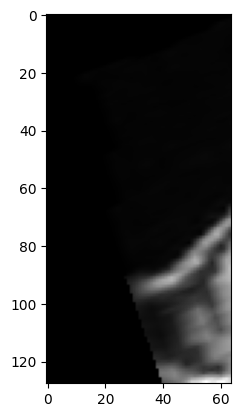

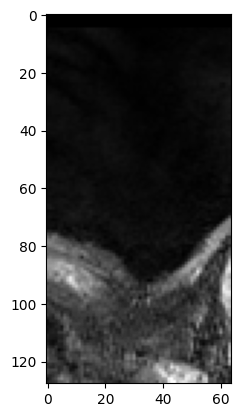

In [68]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(image_sample[0, 0, 34, :, :].numpy(), cmap='gray')
plt.figure()
plt.imshow(label_sample[0, 0, 34, :, :].numpy(), cmap='gray')

## Final Test - looks like the thresholding doesn't remove any patches
### Only removes once threshold gets to 1M - i.e all patches contain a fair amount of label

In [69]:
reader = sitk.ImageFileReader()
reader.SetFileName('/media/hdd/levibaljer/ExperimentingKhula/images/0.nii.gz')
image = reader.Execute()

In [70]:
reader2 = sitk.ImageFileReader()
reader2.SetFileName('/media/hdd/levibaljer/ExperimentingKhula/labels/0.nii.gz')
label = reader2.Execute()

### These are the only preprocessing steps applied in the dataset:

In [71]:
image = Normalization(image)
label = Normalization(label)

castImageFilter = sitk.CastImageFilter()
castImageFilter.SetOutputPixelType(sitk.sitkFloat32)

image = castImageFilter.Execute(image)
label = castImageFilter.Execute(label)

In [80]:
print(image.GetSize())

(144, 256, 256)


### Now obtain a patch from ijk patch indices (unique):

In [79]:
patch_coord = ijk_patch_indices_unique[39][0]
print(patch_coord)

[16, 144, 128, 256, 192, 256]


In [81]:
size_old = image.GetSize()
print(size_old)
size_new = (128, 128, 64)

(144, 256, 256)


In [82]:
roiFilter = sitk.RegionOfInterestImageFilter()
roiFilter.SetSize([size_new[0], size_new[1], size_new[2]])

In [84]:
roiFilter.SetIndex([patch_coord[0], patch_coord[2], patch_coord[4]])

threshold = sitk.BinaryThresholdImageFilter()
threshold.SetLowerThreshold(1)
threshold.SetUpperThreshold(255)
threshold.SetInsideValue(1)
threshold.SetOutsideValue(0)
mask = threshold.Execute(label)
mask_cropped = roiFilter.Execute(mask)
label_crop = roiFilter.Execute(label)
statFilter = sitk.StatisticsImageFilter()
statFilter.Execute(mask_cropped)  # mine for GANs

if statFilter.GetSum() < 0.1:
    print('No label')

In [ ]:
threshold = sitk.BinaryThresholdImageFilter()
threshold.SetLowerThreshold(1)
threshold.SetUpperThreshold(255)
threshold.SetInsideValue(1)
threshold.SetOutsideValue(0)
mask = threshold.Execute(label)
mask_cropped = roiFilter.Execute(mask)
label_crop = roiFilter.Execute(label)
statFilter = sitk.StatisticsImageFilter()
statFilter.Execute(mask_cropped)  # mine for GANs

### All patch coordinates

In [85]:
patch_coords = []
for i in ijk_patch_indices_unique:
    patch_coords.append(i[0])

In [98]:
for i in range(len(patch_coords)):
    patch_coord = patch_coords[i]
    roiFilter = sitk.RegionOfInterestImageFilter()
    roiFilter.SetSize([size_new[0], size_new[1], size_new[2]])
    roiFilter.SetIndex([patch_coord[0], patch_coord[2], patch_coord[4]])
    threshold = sitk.BinaryThresholdImageFilter()
    threshold.SetLowerThreshold(1)
    threshold.SetUpperThreshold(255)
    threshold.SetInsideValue(1)
    threshold.SetOutsideValue(0)
    mask = threshold.Execute(label)
    mask_cropped = roiFilter.Execute(mask)
    label_crop = roiFilter.Execute(label)
    statFilter = sitk.StatisticsImageFilter()
    statFilter.Execute(mask_cropped)  # mine for GANs
    
    if statFilter.GetSum() < 1:
        print('No label')